In [1]:
import pandas as pd
import numpy as np

# mESC

Amadei dataset. (mouse embryos).

In [43]:
data_dir = '/home/ggorin/count_data/amadei/'

In [44]:
names = ['NE{}_{}'.format(x,str(y)) for x in ['65','75'] for y in range(1,3)]+['NE85_{}'.format(str(x)) for x in range(1,7)]

In [48]:
import xlrd
xlrd.xlsx.ensure_elementtree_imported(False, None)
xlrd.xlsx.Element_has_iter = True

In [49]:
meta = pd.read_excel(data_dir+'meta.xlsx')

/tmp/ipykernel_1396580/3630299904.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  meta = pd.read_excel(data_dir+'meta.xlsx')


In [53]:
meta.set_index('barcode')

,celltype,latent_time,type,UMAP_1,UMAP_2
barcode,,,,,
AAACACGGTGGTAACGCCGTGTTT,Epiblast,0.524328,Synthetic,-0.249567,0.602579
AAACACGGTGGTAACGGACAACTT,Gut precursors,0.877421,Synthetic,13.514733,0.282939
AAACACTATGGTAACGCAGTTTGC,Epiblast,0.501554,Synthetic,-2.048857,-0.758087
AAACTGTGTGGTAACGTCCCGTAG,Epiblast,0.611674,Synthetic,1.404837,1.976268
AAAGAAAGTGGTAACGAATCGGGT,Definitive endoderm,0.439383,Synthetic,-1.234815,-5.289140
...,...,...,...,...,...
TGCACCAGCTTGCAGATGTGGCTA,Epiblast,0.039232,natural,NaN,NaN
TGCGACTACTTGCAGAGGTGACAC,Epiblast,0.094287,natural,NaN,NaN
TGGACGGACTTGCAGAATCCCACG,Definitive endoderm,0.314687,natural,NaN,NaN


In [69]:
meta_bcs = meta['barcode']

In [90]:
meta_bcs_natural = meta['barcode'][meta['type']=='natural']

In [95]:
print(f'{len(meta_bcs)} annotated barcodes.\n')
print(f'{len(meta_bcs_natural)} annotated natural barcodes.\n')

data_bcs_all = []
for data_ind, dataset in enumerate(names):
    print(f'Dataset: {dataset}')
    data_str = '/home/ggorin/count_data/amadei/{}.inex.txt'.format(dataset)
    df = pd.read_csv(data_str,sep='\t',nrows = 1 )
    data_bcs = df.columns.str[-24:]
    print(f'\t{len(data_bcs)} barcodes.')
    data_bcs_in_meta = data_bcs[data_bcs.isin(meta_bcs)]
    print(f'\t{len(data_bcs_in_meta)} are in metadata.')
    data_bcs_all.append(data_bcs_in_meta)
data_bcs_all = np.concatenate(data_bcs_all)
print(f'{len(data_bcs_all)} total data barcodes in metadata.')
print(f'{len(np.unique(data_bcs_all))} are unique.')
data_bcs_in_meta = data_bcs_all[pd.Series(data_bcs_all).isin(meta_bcs_natural)]
print(f'{len(data_bcs_in_meta)} are labeled as natural in metadata.')


5419 annotated barcodes.

2653 annotated natural barcodes.

Dataset: NE65_1
	3312 barcodes.
	157 are in metadata.
Dataset: NE65_2
	2442 barcodes.
	104 are in metadata.
Dataset: NE75_1
	6250 barcodes.
	806 are in metadata.
Dataset: NE75_2
	8455 barcodes.
	548 are in metadata.
Dataset: NE85_1
	11875 barcodes.
	116 are in metadata.
Dataset: NE85_2
	9122 barcodes.
	561 are in metadata.
Dataset: NE85_3
	12397 barcodes.
	14 are in metadata.
Dataset: NE85_4
	11662 barcodes.
	84 are in metadata.
Dataset: NE85_5
	11737 barcodes.
	241 are in metadata.
Dataset: NE85_6
	12596 barcodes.
	101 are in metadata.
2732 total data barcodes in metadata.
2732 are unique.
2597 are labeled as natural in metadata.


# MEFs

Schiebinger 2019. Reprogramming.

In [4]:
# import scanpy as sc
# import anndata as ad
import h5py 
import numpy as np

In [10]:
# f = h5py.File('/home/ggorin/count_data/schiebinger/GSM3195680_D8_Dox_C1_gene_bc_mat.h5','r')

In [2]:
f = h5py.File('/home/ggorin/count_data/schiebinger/D95_serum_C1.h5','r')

In [3]:
f['mm10'].keys()

<KeysViewHDF5 ['barcodes', 'data', 'gene_names', 'genes', 'indices', 'indptr', 'shape']>

In [4]:
f['mm10']['data']

<HDF5 dataset "data": shape (2577781,), type "<i4">

In [5]:
f['mm10']['indices'][:10]

array([27994, 27920, 27917, 27916, 27915, 27914, 27913, 27911, 27910,
       27909])

In [12]:

np.savetxt('/home/ggorin/datasets/schiebinger/b2f/D95_serum_C1/whitelist.txt', \
           np.asarray([x[:-2] for x in f['mm10']['barcodes']],dtype=str),fmt='%16s')


In [7]:
DATASET_NAMES=('D75_Dox_C1', 'D8_Dox_C1' ,'D825_serum_C1', 'D85_serum_C1' ,'D875_serum_C1', 'D9_serum_C1', 'D95_serum_C1')
for d in DATASET_NAMES:
    f = h5py.File('/home/ggorin/count_data/schiebinger/{}.h5'.format(d),'r')
    np.savetxt('/home/ggorin/datasets/schiebinger/b2f/{}/whitelist.txt'.format(d), \
               np.asarray([x[:-2] for x in f['mm10']['barcodes']],dtype=str),fmt='%16s')


In [9]:
import loompy as lp

In [13]:
attribute_names=[("unspliced", "spliced"), "gene_name", "barcode"]
layer_names, gene_attr, cell_attr = attribute_names
with lp.connect('/home/ggorin/count_data/schiebinger/D95_serum_C1/counts_unfiltered/adata.loom', mode="r") as ds:
    layers = [ds.layers[layer][:] for layer in layer_names]
    gene_names = ds.ra[gene_attr]
    barcodes = ds.ca[cell_attr]


In [16]:
gene_names


array(['AC125149.3', 'AC125149.1', 'AC125149.4', ..., 'Gm37998',
       'Gm37263', 'Gm37286'], dtype=object)

In [17]:
len(barcodes)

1156

In [19]:
layers = np.asarray(layers,dtype=int)

In [20]:
layers.shape

(2, 32285, 1156)

In [22]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'spliced')

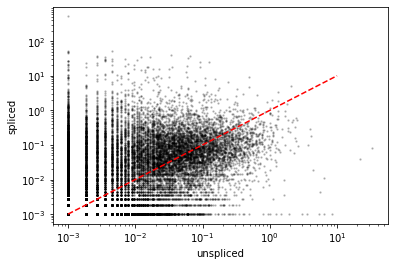

In [37]:
mean_exp = layers.mean(2)
eps=1e-3
plt.scatter(mean_exp[0]+eps,mean_exp[1]+eps,2,'k',alpha=0.2)
xl=[1e-3,1e1]
plt.plot(xl,xl,'r--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('unspliced')
plt.ylabel('spliced')

In [36]:
(mean_exp[0]>mean_exp[1]).sum()

8272

In [38]:
layers

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

D75_Dox_C1: 2591 cells.
D8_Dox_C1: 1879 cells.
D825_serum_C1: 1549 cells.
D85_serum_C1: 1654 cells.
D875_serum_C1: 1616 cells.
D9_serum_C1: 1842 cells.
D95_serum_C1: 1156 cells.


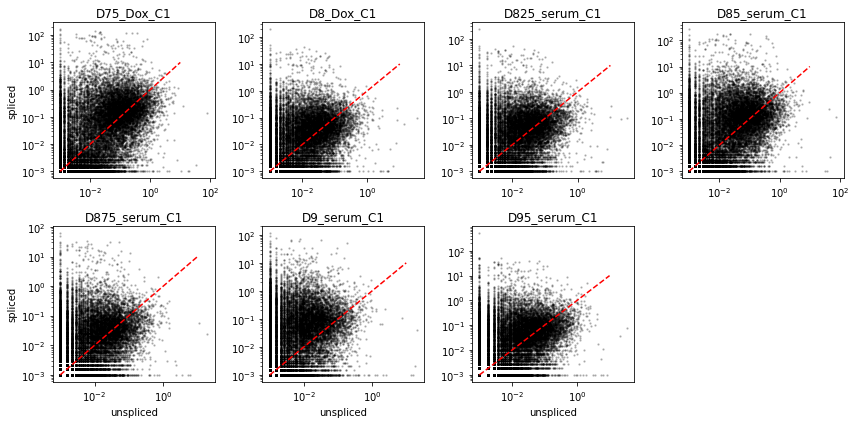

In [51]:
attribute_names=[("unspliced", "spliced"), "gene_name", "barcode"]
layer_names, gene_attr, cell_attr = attribute_names
DATASET_NAMES=('D75_Dox_C1', 'D8_Dox_C1' ,'D825_serum_C1', 'D85_serum_C1' ,'D875_serum_C1', 'D9_serum_C1', 'D95_serum_C1')

fig1,ax1=plt.subplots(2,4,figsize=(12,6))
for k,d in enumerate(DATASET_NAMES):
    axloc = np.unravel_index(k,(2,4))
    
    with lp.connect('/home/ggorin/count_data/schiebinger/{}/counts_unfiltered/adata.loom'.format(d), mode="r") as ds:
        layers = [ds.layers[layer][:] for layer in layer_names]
        gene_names = ds.ra[gene_attr]
        barcodes = ds.ca[cell_attr]
    layers = np.asarray(layers,dtype=int)
    mean_exp = layers.mean(2)
    eps=1e-3
    ax1[axloc].scatter(mean_exp[0]+eps,mean_exp[1]+eps,2,'k',alpha=0.2)
    xl=[1e-3,1e1]
    ax1[axloc].plot(xl,xl,'r--')
    ax1[axloc].set_xscale('log')
    ax1[axloc].set_yscale('log')
    if axloc[0]>0:
        ax1[axloc].set_xlabel('unspliced')
    if axloc[1]==0:
        ax1[axloc].set_ylabel('spliced')
    ax1[axloc].set_title(d)
    print(f'{d}: {len(barcodes)} cells.')
plt.delaxes(ax1[1,3])
fig1.tight_layout()
